In [1]:
from IPython.core.display import display, HTML, Math
display(HTML("<style>.container { width:90% !important; }</style>"))

# im2latex(S): Dataset Filtering

&copy; Copyright 2017 Sumeet S Singh

    This file is part of im2latex solution by Sumeet S Singh.

    This program is free software: you can redistribute it and/or modify
    it under the terms of the Affero GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    Affero GNU General Public License for more details.

    You should have received a copy of the Affero GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

# What This Program Does
This notebook curates the [im2latex-100k dataset from Harvard NLP](https://zenodo.org/record/56198#.WT4fsxMrJE4) from a [Harvard NLP project](http://lstm.seas.harvard.edu/latex/) generated using [their code]( https://github.com/Miffyli/im2latex-dataset).

* This notebook loads the data set which are png files generated using [textogif](https://www.fourmilab.ch/webtools/textogif/textogif.html) (via the abovementioned sourcecode)
* Checks and visualizes the data
* Curates the data - whitening etc.
* Converts it to numpy arrays and finally stores it as pickle files.

In [2]:
from __future__ import print_function
import os
import numpy as np
from IPython.display import display, Image as ipImage
import PIL
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
pd.options.display.max_rows = 600
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 100
pd.options.display.width = 160

In [4]:
data_folder = data_dir = '../data/dataset3'
output_dir = 'step3'
image_folder = image_dir = os.path.join(data_folder, 'formula_images')
dump = False

---
View The Images
---------

Let's take a peek at some of the see what it looks like.

---

#### PNG Format Channels
The PNG files in our data have a varying number of channels (4 and 1). Here's a table from [Wikipedia](https://en.wikipedia.org/wiki/Portable_Network_Graphics) explaining the channels.

<table class="wikitable floatright">
<caption>PNG color options<sup id="cite_ref-15" class="reference"><a href="#cite_note-15">[15]</a></sup></caption>
<tbody><tr>
<th colspan="7">Bits per pixel</th>
</tr>
<tr>
<th rowspan="2">Color option</th>
<th rowspan="2">Channels</th>
<th colspan="5">Bits per channel</th>
</tr>
<tr>
<th>1</th>
<th>2</th>
<th>4</th>
<th>8</th>
<th>16</th>
</tr>
<tr>
<th>Indexed</th>
<th>1</th>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">1</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">2</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">4</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">8</td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
</tr>
<tr>
<th>Grayscale</th>
<th>1</th>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">1</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">2</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">4</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">8</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">16</td>
</tr>
<tr>
<th>Grayscale and alpha</th>
<th>2</th>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">16</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">32</td>
</tr>
<tr>
<th>Truecolor</th>
<th>3</th>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">24</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">48</td>
</tr>
<tr>
<th>Truecolor and alpha</th>
<th>4</th>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">32</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">64</td>
</tr>
</tbody></table>

We'll load files using the flatten=True flag so that the RGB channels get flattened into a single grayscale value.

In [5]:
def displayRandImage(root):
    path = os.path.join(root, np.random.choice(filter(lambda f: f.endswith('.png'),os.listdir(root))));
    image_data = ndimage.imread(path)
    print(path, ' ', image_data.shape)
    display(ipImage(filename=path, format='png', unconfined=True))
#     print(ipImage)
    return [path, image_data, image_data.shape]

../data/dataset3/formula_images/d12c454ab522470_basic.png   (80, 614)


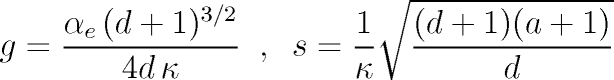

../data/dataset3/formula_images/e32dfdd9408ac89_basic.png   (77, 619)


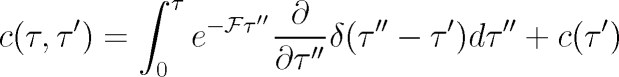

../data/dataset3/formula_images/8042176f4b79c77_basic.png   (68, 442)


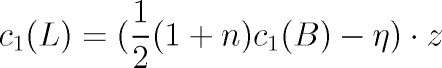

../data/dataset3/formula_images/999e77fab09d54d_basic.png   (36, 373)


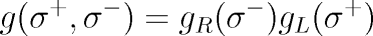

../data/dataset3/formula_images/560fb3a2f57f40b_basic.png   (71, 981)


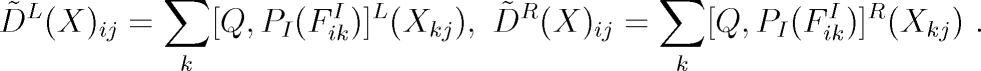

../data/dataset3/formula_images/d3b8cacd9678e65_basic.png   (42, 358)


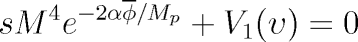

../data/dataset3/formula_images/9516db0031e617a_basic.png   (60, 400, 4)


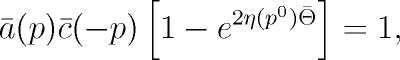

../data/dataset3/formula_images/03fe79416a7d1b1_basic.png   (40, 534)


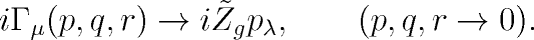

../data/dataset3/formula_images/1dbc37b5b7ea3e8_basic.png   (102, 691)


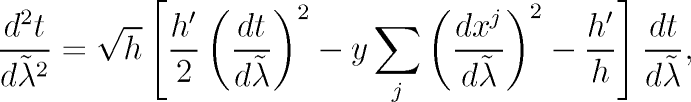

../data/dataset3/formula_images/3a63e50106be5f5_basic.png   (93, 611)


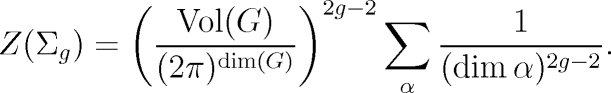

In [6]:
image_details = [displayRandImage(image_folder) for _ in range(10)]

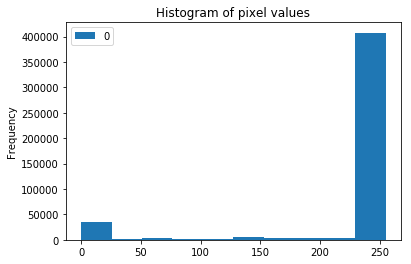

In [7]:
# Histogram the pixel values
vals = np.array([])
for i in range(len(image_details)):
    vals = np.append(vals, image_details[i][1].flatten())


pd.DataFrame(vals).plot.hist(title='Histogram of pixel values')

---
## View Data after Loading into NDArray
---

In [8]:
def loadImage(path, mode="RGB"):
    # Flatten=True collapses the RGB channels into a single grayscale
    #return ndimage.imread(path, flatten=True)
    return ndimage.imread(path, mode=mode)

def _loadImage(path, mode="RGB"):
    img = Image.open(path)
    img = img.convert(mode)
    return np.asarray(img)

def plotImage(path, axes):
    image_data = loadImage(path)
    title = os.path.splitext(os.path.basename(path))[0] + ' %s'%(image_data.shape,)
    axes.set_title( title )
    axes.set_xlim(-10,1500)
    axes.imshow(image_data, aspect='equal', extent=None, resample=False, interpolation='bilinear')
    return [path, image_data, image_data.shape]

def plotImages(image_details, dpi=None):
    """ image_details should be an array of image path and width - [[path, image_data, image_data.shape], ...] """
    ## Display image data loaded as a numpy array
    try:
        plt.close(fig)
    except:
        pass
    orig_dpi = plt.rcParams['figure.dpi']
    image_data = []    
    with mpl.rc_context(rc={'figure.dpi': dpi or orig_dpi}):
        print('dpi set to %d'%mpl.rcParams['figure.dpi'])
        fig = plt.figure(figsize=(15.,3.*len(image_details)))
        grid = ImageGrid(fig, 111, nrows_ncols=(len(image_details),1), axes_pad=(0.1, 0.5), label_mode="L", aspect=False)
        for i in range(len(image_details)):
            image_data.append(plotImage(image_details[i][0], grid[i]))
        
    return image_data

dpi set to 200


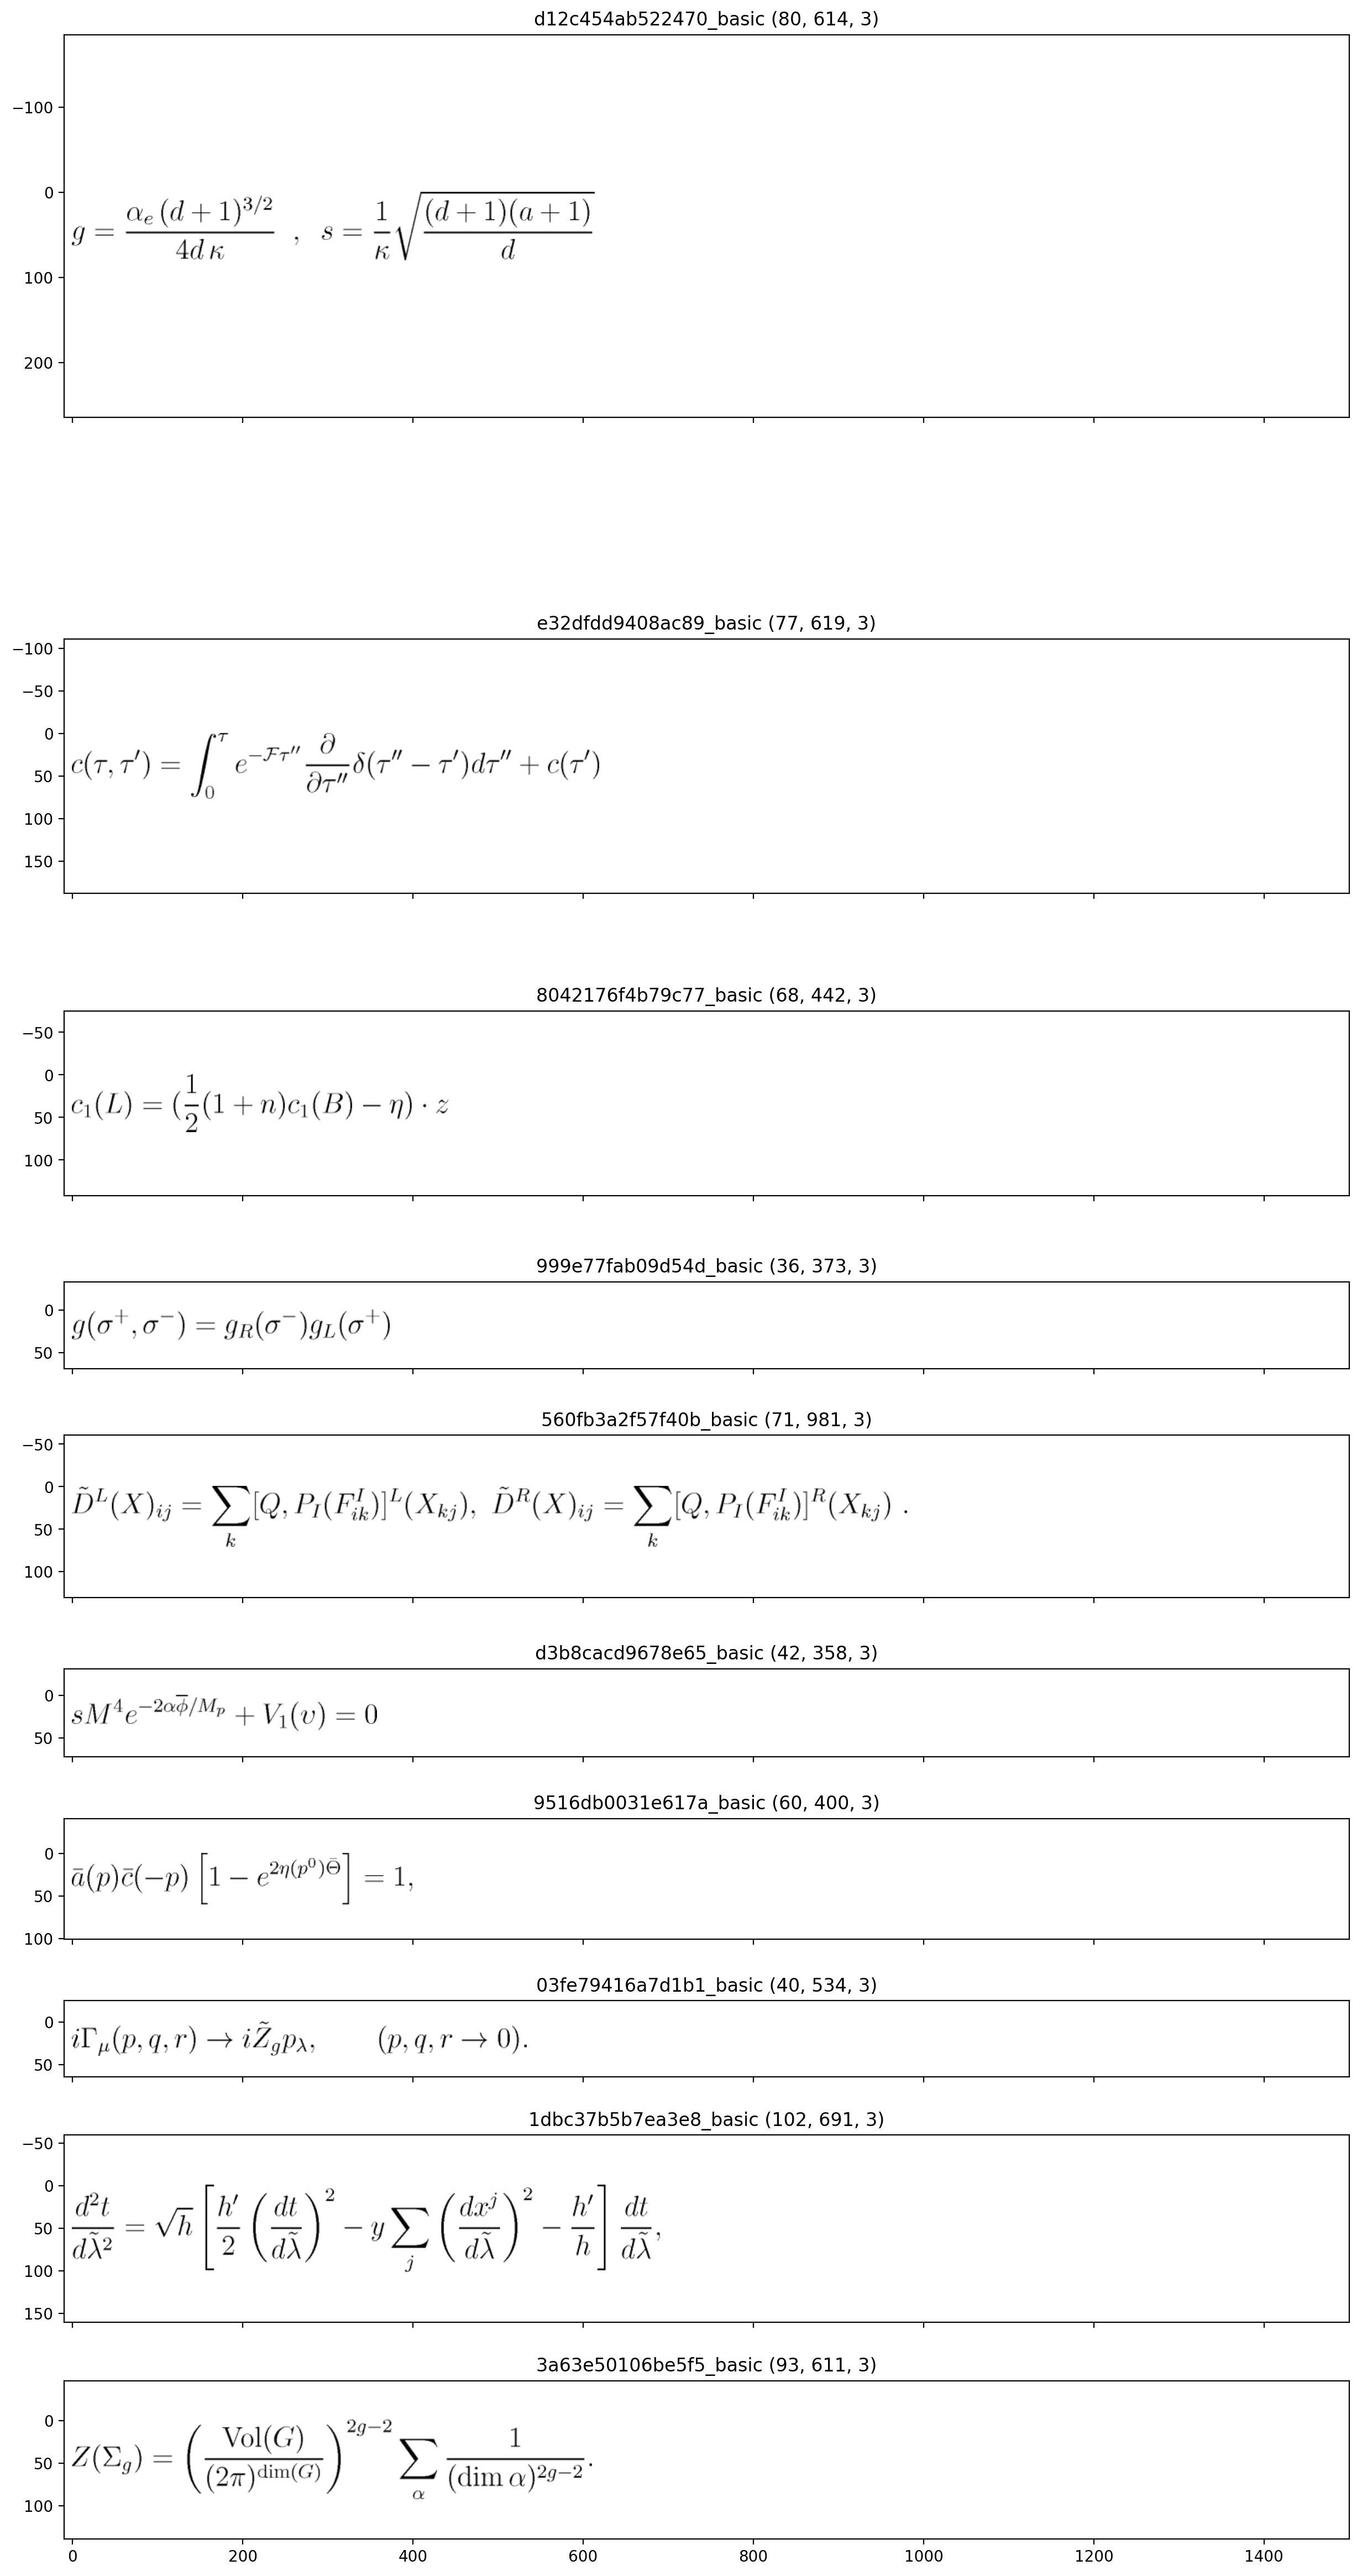

In [9]:
image_details2 = plotImages(image_details, dpi=200)

min pixel=0.000000, max=255.000000


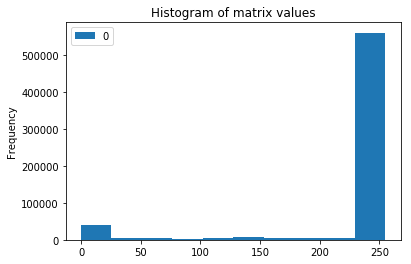

In [10]:
# Histogram of the matrix values
vals2 = np.array([])
for i in range(len(image_details2)):
    vals2 = np.append(vals, image_details2[i][1].flatten())

print ('min pixel=%f, max=%f'%(vals2.min(), vals2.max()))
pd.DataFrame(vals2).plot.hist(title='Histogram of matrix values')

In [11]:
# images = filter(lambda s: s.endswith('.png'), os.listdir(image_folder))
# sizes = []
# for image in images:
#     try:
#         im = Image.open(os.path.join(image_folder,image))
#         sizes.append(im.size)
#     except Exception as e:
#         #print(e)
#         pass
    
# print (len(sizes))
# len(images)

---
## Image Width Analysis
Since images are of varying sizes, we'll need to standardize/quantize their shapes by padding around them. First we need to check the sizes.

---

In [12]:
dff_all = pd.read_pickle(os.path.join(data_folder, 'step2', 'df_word2id.pkl'))

In [13]:
dff_all.shape

(99530, 10)

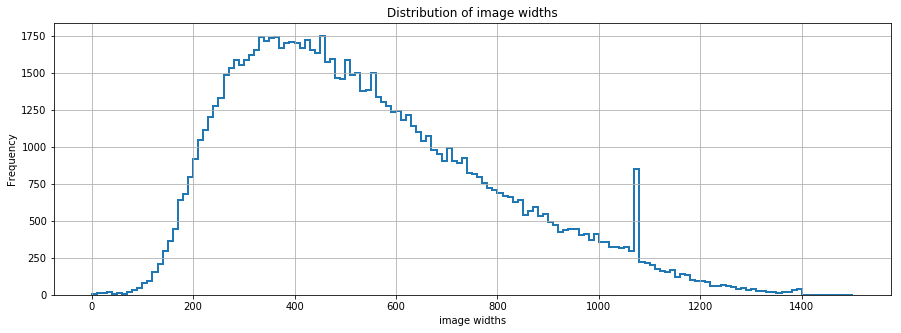

In [14]:
axes = plt.axes()
axes.set_xlabel('image widths')
axes.set_title('Distribution of image widths')
bins=range(0,1501,10)
dff_all['width'].plot.hist(histtype='step', bins=bins, figsize=(15,5), grid=True, lw=2)

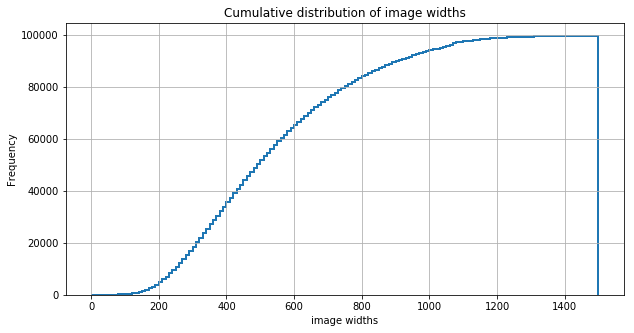

In [15]:
axes = plt.axes()
axes.set_xlabel('image widths')
axes.set_ylabel('Cumulative Count')
axes.set_title('Cumulative distribution of image widths')
dff_all['width'].plot.hist(histtype='step',bins=range(0,1501,10), figsize=(10,5), grid=True, cumulative=True, lw=2)

In [16]:
dff_all.width.quantile((.60,.65,.70,.75,.80,.85,.90,.95,.96,.97,.98, .984,.99,1.0))

0.600     565.0
0.650     605.0
0.700     647.0
0.750     696.0
0.800     751.0
0.850     819.0
0.900     904.0
0.950    1026.0
0.960    1056.0
0.970    1076.0
0.980    1115.0
0.984    1140.0
0.990    1184.0
1.000    1402.0
Name: width, dtype: float64

###### Conclusion of Width Analysis
We'll standardize the width of all images to 1086 by padding the smaller ones. Furthermore, we will pad all images to a width of 1088 (which is a multiple of 32 and therefore will work nicely with the 5 Max-Pooling layers of VGG16). We need the extra 2 pixels over the max image-width in order to fit a convolution kernel of size (3,3) with VALID padding. If we were going to use a bigger kernel, we would need to reduce the max image-width appropriately.
We could've gone with a much lower number - specifically the 85% cutoff point but that would've left us with only 80K samples. At this time we want to ensure close to 100K samples, therefore we'll settle for a width of 1086, which gives us almost 95K samples.

In [17]:
dff_w = dff_all[dff_all.width <= 1086]
dff_w.shape

(96949, 10)

In [18]:
dff_w.max()

image                                                                                        ffff8ef99cabb12_basic.png
formula_name                                                                                     ffff8ef99cabb12_basic
latex              ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ - 2 \int _ { B _ { t } } d ^ { ( D - 1 ) } x \, r _ { \alpha } \pi...
formula_len                                                                                                       2177
height                                                                                                             687
width                                                                                                             1086
latex_ascii        ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ - 2 \int _ { B _ { t } } d ^ { ( D - 1 ) } x \, r _ { \alpha } \pi...
latex_tokenized    [~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, -, 2, \int, _, {, B, _, {, t, }, }, d, ^, {, (, D,...
word2id            [356, 356, 356, 356, 356, 356

### Image Height Analysis

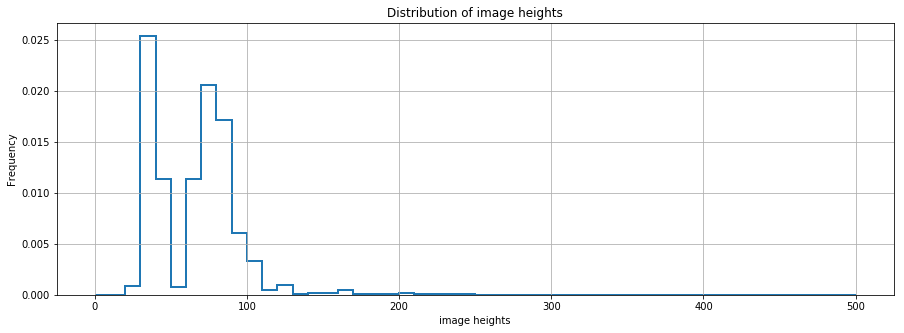

In [19]:
axes = plt.axes()
axes.set_xlabel('image heights')
axes.set_title('Distribution of image heights')
bins=range(0,501,10)
dff_w['height'].plot.hist(ax=axes, histtype='step', lw=2, bins=bins, figsize=(15,5), grid=True, normed=True)

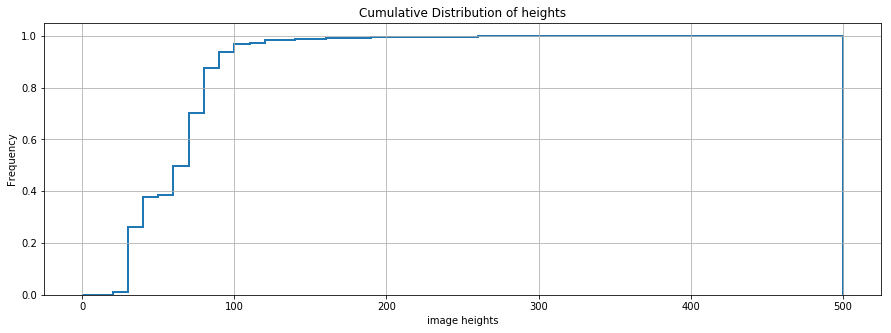

In [20]:
axes = plt.axes()
axes.set_xlabel('image heights')
axes.set_title('Cumulative Distribution of heights')
bins=range(0,501,10)
dff_w['height'].plot.hist(histtype='step', lw=2, bins=bins, figsize=(15,5), grid=True, normed=True, cumulative=True)

In [21]:
display(dff_w.height.quantile((.85,.90,.95,.96,.97,.98,.985,.99,1.0)))

0.850     86.0
0.900     92.0
0.950    100.0
0.960    102.0
0.970    110.0
0.980    121.0
0.985    140.0
0.990    160.0
1.000    687.0
Name: height, dtype: float64

In [22]:
dff_wh = dff_w[dff_w.height<=126]
dff_wh.shape

(95231, 10)

## Conclusion
Note that there is a big difference between the 99% and 100% height values. And since the image is much wider than it is tall, a reduction in the height of the image will be much more impactful than a similar reduction in its width. Hence, we'll select images that are 126 or fewer pixels high. That will leave us with ~94K samples. As explained above, the padded image height will be 128 (again, a multiple of 2^5).

In conclusion, we'll set all images to a size of 128 x 1088 with a padding of whites (value 255). Images taller than 126 or wider than 1086 be discarded from the training, validation or test sets.

Furthermore, the images will be batched together according to the sequence length of the formulas.

In [23]:
dff_wh.max()

image                                                                                        ffff8ef99cabb12_basic.png
formula_name                                                                                     ffff8ef99cabb12_basic
latex              ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ - 2 \int _ { B _ { t } } d ^ { ( D - 1 ) } x \, r _ { \alpha } \pi...
formula_len                                                                                                       1286
height                                                                                                             126
width                                                                                                             1086
latex_ascii        ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ - 2 \int _ { B _ { t } } d ^ { ( D - 1 ) } x \, r _ { \alpha } \pi...
latex_tokenized    [~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, -, 2, \int, _, {, B, _, {, t, }, }, d, ^, {, (, D,...
word2id            [356, 356, 356, 356, 356, 356

### Persist

In [24]:
if dump and (not os.path.exists(os.path.join(data_dir, output_dir))) :
    os.makedirs(os.path.join(data_dir, output_dir))
padded_image_dim = {'height':128, 'width':1088}
if dump:
    with open(os.path.join(data_dir, output_dir, 'padded_image_dim.pkl'), 'wb') as f:
        pickle.dump(padded_image_dim, f, pickle.HIGHEST_PROTOCOL)

-------
## Latex Word Sequence Lengths

-------

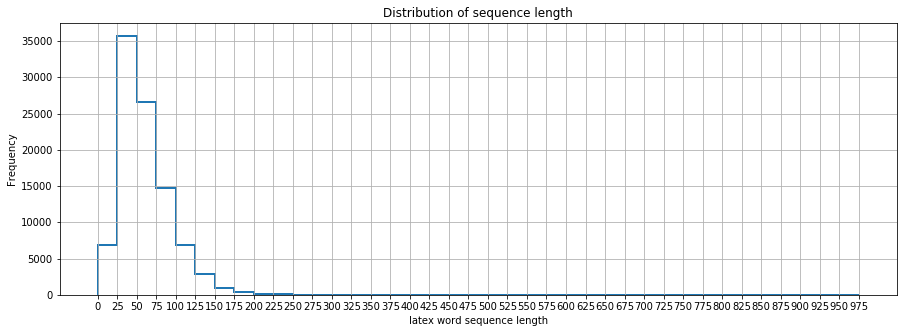

In [25]:
axes = plt.axes()
axes.set_xlabel('latex word sequence length')
axes.set_title('Distribution of sequence length')
bins=range(0,1000,25)
dff_wh.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=bins, xticks=bins)

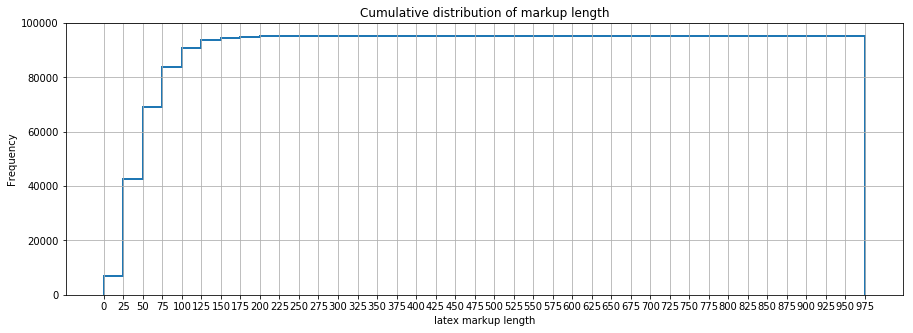

In [26]:
axes = plt.axes()
axes.set_xlabel('latex markup length')
axes.set_title('Cumulative distribution of markup length')
bins=range(0,1000,25)
dff_wh.word2id_len.plot.hist(ax=axes, histtype='step', lw=2, bins=bins, xticks=bins, figsize=(15,5), grid=True, cumulative=True)

In [27]:
display(dff_wh.word2id_len.quantile((.60,.70,.75,.80,.85,.90,.95,.97,.98,.99,1.0)))

0.60     61.0
0.70     71.0
0.75     77.0
0.80     85.0
0.85     93.0
0.90    104.0
0.95    123.0
0.97    135.0
0.98    145.0
0.99    163.0
1.00    414.0
Name: word2id_len, dtype: float64

###### Conclusion of Formula Length Analyses
For training efficiency it will be desirable to batch together formulas of equal length. Also, since 95% of the formulas are below 150 tokens long, we'll limit our training set to under 150 tokens - which will leave us with ~96K samples (see below).

In [28]:
dff_lwh = dff_wh[dff_wh.word2id_len <= 150]
print(dff_lwh.shape[0])

93741


In [29]:
# dff_lwh.word2id_len.apply(lambda x: x**2).describe()
dff_lwh.word2id_len.describe()

count    93741.000000
mean        58.759785
std         28.820789
min          1.000000
25%         37.000000
50%         53.000000
75%         76.000000
max        150.000000
Name: word2id_len, dtype: float64

In [30]:
display(dff_lwh[['word2id_len', 'width', 'height']].corr())
display(dff_lwh.max())

,word2id_len,width,height
word2id_len,1.000000,0.818235,0.409761
width,0.818235,1.000000,0.224680
height,0.409761,0.224680,1.000000


image                                                                                        ffff8ef99cabb12_basic.png
formula_name                                                                                     ffff8ef99cabb12_basic
latex              ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ - 2 \int _ { B _ { t } } d ^ { ( D - 1 ) } x \, r _ { \alpha } \pi...
formula_len                                                                                                        595
height                                                                                                             126
width                                                                                                             1086
latex_ascii        ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ - 2 \int _ { B _ { t } } d ^ { ( D - 1 ) } x \, r _ { \alpha } \pi...
latex_tokenized    [~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, -, 2, \int, _, {, B, _, {, t, }, }, d, ^, {, (, D,...
word2id            [356, 356, 356, 356, 356, 356

In [31]:
dff_lwh.max()

image                                                                                        ffff8ef99cabb12_basic.png
formula_name                                                                                     ffff8ef99cabb12_basic
latex              ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ - 2 \int _ { B _ { t } } d ^ { ( D - 1 ) } x \, r _ { \alpha } \pi...
formula_len                                                                                                        595
height                                                                                                             126
width                                                                                                             1086
latex_ascii        ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ - 2 \int _ { B _ { t } } d ^ { ( D - 1 ) } x \, r _ { \alpha } \pi...
latex_tokenized    [~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, ~, -, 2, \int, _, {, B, _, {, t, }, }, d, ^, {, (, D,...
word2id            [356, 356, 356, 356, 356, 356

In [32]:
if dump:
    dff_lwh.to_pickle(os.path.join(data_folder, output_dir, 'df_pruned.pkl'))

## Pixel Value Analysis
Find out if we can simplify the dataset to bitmaps. This would greatly simplify the learning and also reduce the memory required for storing the data.
### Note: Some LaTeX commands produce bold fonts, therefore it would be incorrect to flatten the values to 1s and 0s. Hence we'll skip this step

In [33]:
# def getValuesDF(dff, data_dir, generate=False):
#     try:
#         return pd.read_pickle(os.path.join(data_dir, output_dir, 'df_lwh_pixel_dist.pkl'))
#     except:
#         if not generate:
#             raise
#         vals = pd.Series([])
#         for filename in dff.image:
#             image_data = ndimage.imread(os.path.join(image_dir,filename), mode='L')
#             vals = vals.add(pd.Series(image_data.flatten()).value_counts(), fill_value=0)

#         dV = pd.DataFrame({'pixel_value':vals.index, 'val_count':vals}, columns=['pixel_value', 'val_count'])
#         if dump:
#             dV.to_pickle(os.path.join(data_dir, output_dir, 'df_lwh_pixel_dist.pkl'))
#         return dV

# dV = getValuesDF(dff_lwh, data_folder, generate=True)
# dV.T

In [34]:
# axes = plt.axes()
# axes.set_xlabel('pixel values')
# axes.set_ylabel('log(val_count)')
# axes.set_title('pixel value log(distribution)')
# dV['val_count'].plot(ax=axes, kind='line', figsize=(10,5), xticks=range(0,255, 10), logy=True, linewidth=2, grid=True, xlim=(-10, 265))

In [35]:
# axes = plt.axes()
# axes.set_xlabel('pixel values')
# axes.set_ylabel('cumulative % count')
# ((dV['val_count'].cumsum() / dV['val_count'].sum())*100).plot(ax=axes, kind='area', figsize=(10,5), xticks=range(0,255, 10), yticks=range(0,101,5), linewidth=2, grid=True, xlim=(-10, 265), ylim=(-5, 105), title='pixel value cumulative sum')